In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/kaggle-nabil-badri/dataset-hatespeech+rumor/hatespeech_text_label_vote - hatespeech_text_label_vote.csv')

In [ ]:
df.head()

,text,label,Unnamed: 2
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam,4
1,RT @Papapishu: Man it would fucking rule if we...,abusive,4
2,It is time to draw close to Him &#128591;&#127...,normal,4
3,if you notice me start to act different or dis...,normal,5
4,"Forget unfollowers, I believe in growing. 7 ne...",normal,3


In [ ]:
df.shape

(99996, 3)

In [ ]:
X = df.text
y = df.label
y = pd.factorize(y)[0]
Y = keras.utils.to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [ ]:
_,_,_,y_test_p = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [ ]:
import collections
collections.Counter(y)

Counter({0: 14030, 1: 27150, 2: 53851, 3: 4965})

In [ ]:
x=x_train[225].lower().replace('@user','').replace('url','')
x=re.sub('[^A-Za-z]', ' ', x)
re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x)

'ty     papittsburgh  hsd academics  hermitagepa pd for partnering for  danielslaw outreach https   t co lkfsvgfys '

In [ ]:
# Creating the training corpus
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
corpus_train = []
for i in x_train:
    x=i.lower()
    x=x.replace('@user','')
    x=x.replace('@[\w\-]+','')
    #x=x.translate(str.maketrans('', '', string.punctuation))
    x = re.sub('[^A-Za-z]', ' ', x)
    #x=re.sub('\s+',' ',x)
    x=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x) #url
    #x = [lemmatizer.lemmatize(token) for token in x.split(" ")]
    #x = [word for word in x if not word in stop_words]
    #x=" ".join(x)
    corpus_train.append(x)    
# Creating the training corpus
corpus_test = []
for i in x_test:
    x=i.lower()
    x=x.replace('@user','')
    x=x.replace('@[\w\-]+','')
    #x=x.translate(str.maketrans('', '', string.punctuation))
    x = re.sub('[^A-Za-z]', ' ', x)
    #x=re.sub('\s+',' ',x)
    x=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x) #url
    #x = [lemmatizer.lemmatize(token) for token in x.split(" ")]
    #x = [word for word in x if not word in stop_words]
    #x=" ".join(x)
    corpus_test.append(x) 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_words = 5000 #frequency of words to be kept
max_len = 200

tokenize = Tokenizer(num_words=max_words)
tokenize.fit_on_texts(corpus_train)
sequences = tokenize.texts_to_sequences(corpus_train)
word_index = tokenize.word_index
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
num_words = min(max_words, len(word_index)) + 1
print(num_words)

5001


In [ ]:
!unzip /content/drive/MyDrive/kaggle-nabil-badri/wikinews300d1mvec.zip

Archive:  /content/drive/MyDrive/kaggle-nabil-badri/wikinews300d1mvec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
embedding_path1 = "/content/wiki-news-300d-1M.vec"
embedding_path2 = "/content/drive/MyDrive/kaggle-nabil-badri/glove.840B.300d.txt"
embed_size = 300

In [ ]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def build_matrix(embedding_path, word_index):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

    nb_words = min(max_words, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    for word, i in word_index.items():
        if i >= max_words:
            continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
fasttext=build_matrix(embedding_path1, word_index)
glove_emb=build_matrix(embedding_path2, word_index)

In [ ]:
embedding_matrix=np.mean((fasttext,glove_emb),axis=0)
embedding_matrix.shape

(5001, 300)

In [ ]:
test_sequences = tokenize.texts_to_sequences(corpus_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
from keras import backend as K
def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.callbacks import Callback
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='val_f1', value=0.87, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [ ]:
callbacks = keras.callbacks.EarlyStopping(monitor='val_f1', mode='max', verbose=1,
                                          patience=8,restore_best_weights = True)

In [ ]:
from keras.models import Sequential,Model
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from keras.layers import Embedding,Dense,GRU
from keras.layers import Dropout,Bidirectional,GlobalMaxPool1D,GlobalAveragePooling1D
from keras.layers import SpatialDropout1D,concatenate,Input
from keras.optimizers import RMSprop
from keras.initializers import Constant
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights=dict(enumerate(class_weights))

# BIGRUs Model

### Training a model with GloVe and Fasttext embedding

In [ ]:
inp=Input(shape=(max_len, ))
x=Embedding(num_words,embed_size,embeddings_initializer=Constant(embedding_matrix),
            input_length=max_len,trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x=Bidirectional(CuDNNGRU(150, return_sequences = True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])


x=Dropout(0.1)(conc)
out=Dense(64, activation="relu")(x)
out=Dense(32, activation="relu")(x)

out=Dense(4, activation="softmax")(x)

model=Model(inp,out)

mcp_save = ModelCheckpoint('/content/sample_data/model.mdl_wts.hdf5', save_best_only=True,
                           monitor='val_loss', mode='min',patience = 5)



In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     1500300     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 300)     406800      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

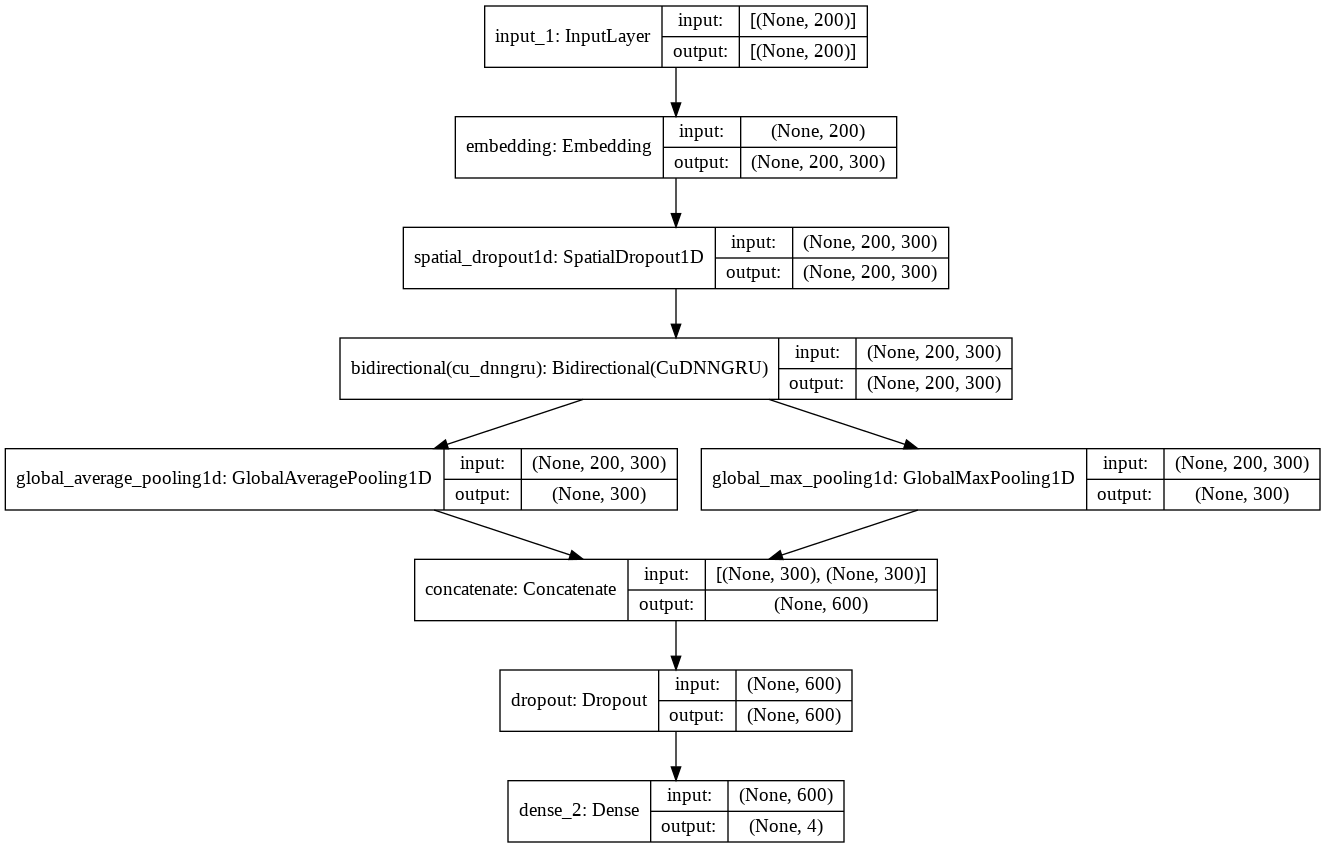

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=30,verbose=1,class_weight=class_weights,
          validation_data=(test_sequences_matrix,y_test),callbacks=[callbacks])

Epoch 1/30
625/625 [==============================] - 97s 144ms/step - loss: 0.8432 - f1: 0.5334 - val_loss: 0.7196 - val_f1: 0.6794
Epoch 2/30
625/625 [==============================] - 89s 142ms/step - loss: 0.6790 - f1: 0.6904 - val_loss: 0.6071 - val_f1: 0.7516
Epoch 3/30
625/625 [==============================] - 89s 142ms/step - loss: 0.6626 - f1: 0.7059 - val_loss: 0.6258 - val_f1: 0.7427
Epoch 4/30
625/625 [==============================] - 89s 142ms/step - loss: 0.6459 - f1: 0.7133 - val_loss: 0.6898 - val_f1: 0.7075
Epoch 5/30
625/625 [==============================] - 89s 142ms/step - loss: 0.6168 - f1: 0.7229 - val_loss: 0.8634 - val_f1: 0.5973
Epoch 6/30
625/625 [==============================] - 89s 142ms/step - loss: 0.6068 - f1: 0.7256 - val_loss: 0.7163 - val_f1: 0.6830
Epoch 7/30
625/625 [==============================] - 89s 143ms/step - loss: 0.5847 - f1: 0.7339 - val_loss: 0.6563 - val_f1: 0.7235
Epoch 8/30
625/625 [==============================] - 89s 142ms/step 

In [ ]:
print(model.evaluate(test_sequences_matrix,y_test))

625/625 [==============================] - 28s 44ms/step - loss: 0.6071 - f1: 0.7509
[0.607116162776947, 0.7508711218833923]


In [ ]:
y_pred = model.predict(test_sequences_matrix, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

157/157 [==============================] - 8s 48ms/step


In [ ]:
print(classification_report(y_test_p, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.72      0.60      2817
           1       0.88      0.85      0.87      5369
           2       0.89      0.74      0.81     10848
           3       0.31      0.59      0.41       966

    accuracy                           0.76     20000
   macro avg       0.65      0.73      0.67     20000
weighted avg       0.81      0.76      0.78     20000



In [ ]:
from tensorflow import keras
keras.backend.clear_session()

In [ ]:
from sklearn import metrics

In [ ]:
metric =metrics.accuracy_score(y_test_p, y_pred), metrics.f1_score(y_test_p, y_pred, average='macro'), metrics.recall_score(y_test_p, y_pred,average='macro'), metrics.precision_score(y_test_p, y_pred,average='macro')

(0.0, 1.0)

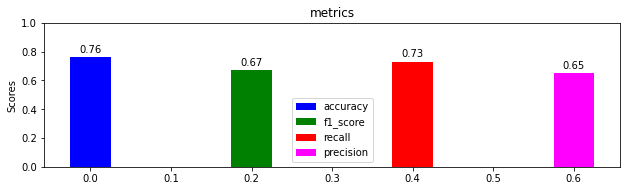

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,2)
ax = fig.add_axes([0,0,1,1])
rect1 = ax.bar(0.00,round(metric[0], 2), color = 'b', width = 0.05)
rect2 = ax.bar(0.20, round(metric[1], 2), color = 'g', width = 0.05)
rect3 = ax.bar(0.40, round(metric[2], 2) , color = 'r', width = 0.05)
rect4 = ax.bar(0.60, round(metric[3], 2) , color = (1, 0, 1), width = 0.05)

ax.set_ylabel('Scores')
ax.set_title('metrics')
def autolabel(rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)
ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
plt.ylim(0, 1)

### Training on Fasttext Embedding Only

In [ ]:
keras.backend.clear_session()

In [ ]:
inp=Input(shape=(max_len, ))
x=Embedding(num_words,embed_size,embeddings_initializer=Constant(fasttext),#Set Fasttext Embedding
            input_length=max_len,trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x=Bidirectional(GRU(150, return_sequences = True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])


x=Dropout(0.1)(conc)
out=Dense(64, activation="relu")(x)
out=Dense(32, activation="relu")(x)

out=Dense(4, activation="softmax")(x)

model_ft=Model(inp,out)

mcp_save = ModelCheckpoint('/content/sample_data/model.mdl_wts.hdf5', save_best_only=True,
                           monitor='val_loss', mode='min',patience = 5)


In [ ]:
model_ft.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

In [ ]:
model_ft.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     1500300     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 300)     406800      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
model_ft.fit(sequences_matrix,y_train,batch_size=128,epochs=30,verbose=1,class_weight=class_weights,
          validation_data=(test_sequences_matrix,y_test),callbacks=[callbacks])

Epoch 1/30
625/625 [==============================] - 36s 55ms/step - loss: 0.8709 - f1: 0.5063 - val_loss: 0.6293 - val_f1: 0.7355
Epoch 2/30
625/625 [==============================] - 33s 54ms/step - loss: 0.6845 - f1: 0.7006 - val_loss: 0.6818 - val_f1: 0.7066
Epoch 3/30
625/625 [==============================] - 33s 54ms/step - loss: 0.6612 - f1: 0.7100 - val_loss: 0.7712 - val_f1: 0.6576
Epoch 4/30
625/625 [==============================] - 34s 54ms/step - loss: 0.6563 - f1: 0.7064 - val_loss: 0.6809 - val_f1: 0.7091
Epoch 5/30
625/625 [==============================] - 34s 54ms/step - loss: 0.6322 - f1: 0.7236 - val_loss: 0.6540 - val_f1: 0.7231
Epoch 6/30
625/625 [==============================] - 34s 54ms/step - loss: 0.6183 - f1: 0.7269 - val_loss: 0.7035 - val_f1: 0.6929
Epoch 7/30
625/625 [==============================] - 33s 54ms/step - loss: 0.6123 - f1: 0.7328 - val_loss: 0.6872 - val_f1: 0.7012
Epoch 8/30
625/625 [==============================] - 33s 53ms/step - loss: 

In [ ]:
print(model_ft.evaluate(test_sequences_matrix,y_test))

625/625 [==============================] - 7s 11ms/step - loss: 0.5920 - f1: 0.7550
[0.5920288562774658, 0.755021333694458]


In [ ]:
y_pred_ft = model_ft.predict(test_sequences_matrix, batch_size=128, verbose=1)
y_pred_ft = np.argmax(y_pred_ft, axis=1)

print(classification_report(y_test_p, y_pred_ft))


157/157 [==============================] - 3s 21ms/step
              precision    recall  f1-score   support

           0       0.47      0.78      0.59      2817
           1       0.89      0.85      0.87      5369
           2       0.90      0.74      0.81     10848
           3       0.38      0.53      0.45       966

    accuracy                           0.76     20000
   macro avg       0.66      0.72      0.68     20000
weighted avg       0.81      0.76      0.78     20000



In [ ]:
metric_ft=metrics.accuracy_score(y_test_p, y_pred_ft), metrics.f1_score(y_test_p, y_pred_ft, average='macro'), metrics.recall_score(y_test_p, y_pred_ft,average='macro'), metrics.precision_score(y_test_p, y_pred_ft,average='macro')

(0.0, 1.0)

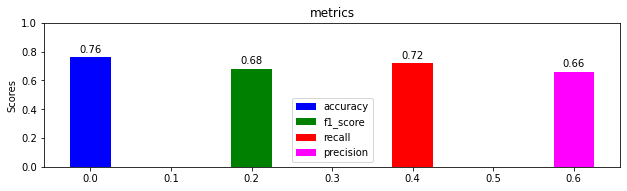

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,2)
ax = fig.add_axes([0,0,1,1])
rect1 = ax.bar(0.00,round(metric_ft[0], 2), color = 'b', width = 0.05)
rect2 = ax.bar(0.20, round(metric_ft[1], 2), color = 'g', width = 0.05)
rect3 = ax.bar(0.40, round(metric_ft[2], 2) , color = 'r', width = 0.05)
rect4 = ax.bar(0.60, round(metric_ft[3], 2) , color = (1, 0, 1), width = 0.05)

ax.set_ylabel('Scores')
ax.set_title('metrics')


autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)
ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
plt.ylim(0, 1)

### Training on Glove Embedding

In [ ]:
keras.backend.clear_session()

In [ ]:
inp=Input(shape=(max_len, ))
x=Embedding(num_words,embed_size,embeddings_initializer=Constant(glove_emb),#Set GloVe Embedding
            input_length=max_len,trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x=Bidirectional(GRU(150, return_sequences = True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])


x=Dropout(0.1)(conc)
out=Dense(64, activation="relu")(x)
out=Dense(32, activation="relu")(x)

out=Dense(4, activation="softmax")(x)

model_gl=Model(inp,out)

mcp_save = ModelCheckpoint('/content/sample_data/model.mdl_wts.hdf5', save_best_only=True,
                           monitor='val_loss', mode='min',patience = 5)


In [ ]:
model_gl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

In [ ]:
model_gl.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     1500300     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 300)     406800      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
model_gl.fit(sequences_matrix,y_train,batch_size=128,epochs=30,verbose=1,class_weight=class_weights,
          validation_data=(test_sequences_matrix,y_test),callbacks=[callbacks])

Epoch 1/30
625/625 [==============================] - 34s 53ms/step - loss: 0.8036 - f1: 0.5669 - val_loss: 0.7218 - val_f1: 0.6729
Epoch 2/30
625/625 [==============================] - 34s 54ms/step - loss: 0.6734 - f1: 0.7022 - val_loss: 0.6384 - val_f1: 0.7285
Epoch 3/30
625/625 [==============================] - 33s 53ms/step - loss: 0.6411 - f1: 0.7154 - val_loss: 0.6833 - val_f1: 0.7062
Epoch 4/30
625/625 [==============================] - 33s 53ms/step - loss: 0.6275 - f1: 0.7204 - val_loss: 0.6842 - val_f1: 0.7039
Epoch 5/30
625/625 [==============================] - 33s 53ms/step - loss: 0.6091 - f1: 0.7257 - val_loss: 0.7083 - val_f1: 0.6861
Epoch 6/30
625/625 [==============================] - 33s 53ms/step - loss: 0.5979 - f1: 0.7250 - val_loss: 0.6036 - val_f1: 0.7472
Epoch 7/30
625/625 [==============================] - 33s 53ms/step - loss: 0.5759 - f1: 0.7411 - val_loss: 0.6289 - val_f1: 0.7365
Epoch 8/30
625/625 [==============================] - 33s 53ms/step - loss: 

In [ ]:
print(model_gl.evaluate(test_sequences_matrix,y_test))

625/625 [==============================] - 7s 10ms/step - loss: 0.6036 - f1: 0.7469
[0.6036179661750793, 0.7469402551651001]


In [ ]:
y_pred_gl = model_gl.predict(test_sequences_matrix, batch_size=128, verbose=1)
y_pred_gl = np.argmax(y_pred_gl, axis=1)
y_pred_gl = (y_pred_gl > 0.5)

print(classification_report(y_test_p, y_pred_gl))


157/157 [==============================] - 3s 21ms/step
              precision    recall  f1-score   support

           0       0.45      0.80      0.58      2817
           1       0.35      0.98      0.51      5369
           2       0.00      0.00      0.00     10848
           3       0.00      0.00      0.00       966

    accuracy                           0.37     20000
   macro avg       0.20      0.44      0.27     20000
weighted avg       0.16      0.37      0.22     20000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metric_gl =metrics.accuracy_score(y_test_p, y_pred_gl), metrics.f1_score(y_test_p, y_pred_gl, average='macro'), metrics.recall_score(y_test_p, y_pred_gl, average='macro'), metrics.precision_score(y_test_p, y_pred_gl, average='macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 1.0)

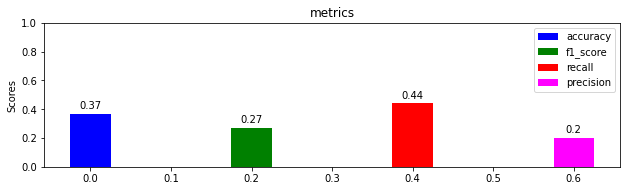

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,2)
ax = fig.add_axes([0,0,1,1])
rect1 = ax.bar(0.00,round(metric_gl[0], 2), color = 'b', width = 0.05)
rect2 = ax.bar(0.20, round(metric_gl[1], 2), color = 'g', width = 0.05)
rect3 = ax.bar(0.40, round(metric_gl[2], 2) , color = 'r', width = 0.05)
rect4 = ax.bar(0.60, round(metric_gl[3], 2) , color = (1, 0, 1), width = 0.05)

ax.set_ylabel('Scores')
ax.set_title('metrics')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)
ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
plt.ylim(0, 1)

### Comparing the three results

In [ ]:
Data = [('Fasttext',) + metric_ft  ,
        ('GloVe',)+ metric_gl ,
         ('Fasttext + GloVe',)+ metric ]

In [ ]:
Results = pd.DataFrame(data =  Data , columns=['Embedding','Accuracy','F1_score','Recall','Precision'])

In [ ]:
Results

,Embedding,Accuracy,F1_score,Recall,Precision
0,Fasttext,0.76185,0.677040,0.723482,0.659887
1,GloVe,0.37470,0.273241,0.444240,0.200537
2,Fasttext + GloVe,0.76785,0.674281,0.717792,0.653248
